In [94]:
from typing import List
from itertools import combinations
import numpy as np
import dask.dataframe as dd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [95]:
dir = "./data/circle_spike_tail/"
real = dd.read_parquet(dir+"main.parquet", columns=["spec","variant","real.tests", "real.downs", "size", "clocks"])
squished = dd.read_parquet(dir+"squished.parquet", columns=["spec","variant","approx.tests", "approx.downs", "limit.tests", "limit.downs"])
opti = dd.read_parquet(dir+"opti/init_weights.min_front.parquet", index=["spec"],columns=["variant","comb", "real.tests", "real.downs"])
squished = squished.groupby(["spec", "variant"]).max()

real_max = real.groupby(["spec", "variant"]).max()

In [96]:
comparison_squished = real_max.join(squished, on=["spec", "variant"]).compute()

### Difference percentage limit vs real max

<AxesSubplot:xlabel='spec'>

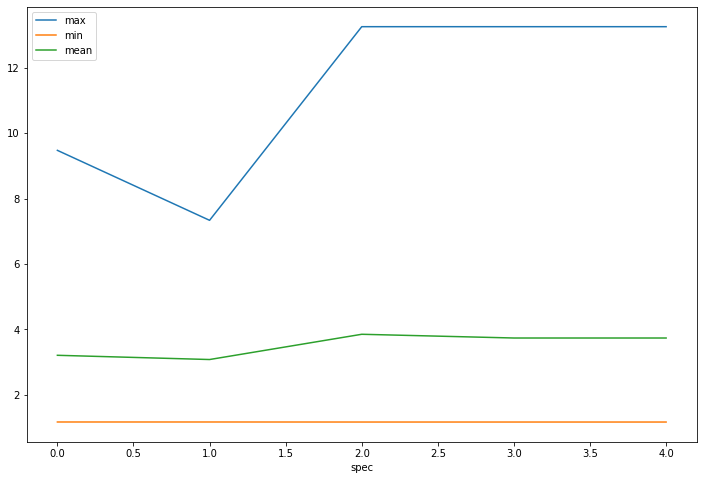

In [97]:
(comparison_squished["limit.tests"]/comparison_squished["real.tests"]).groupby("spec").agg(["max", "min", "mean"]).plot(figsize=(12,8))

### Specifications that fails to be approximated correctly

In [98]:
comparison_squished[comparison_squished["approx.tests"] < comparison_squished["real.tests"]]

,,real.tests,real.downs,size,clocks,approx.tests,approx.downs,limit.tests,limit.downs
spec,variant,,,,,,,,


### Raw limit vs real max percentage

<AxesSubplot:xlabel='spec,variant'>

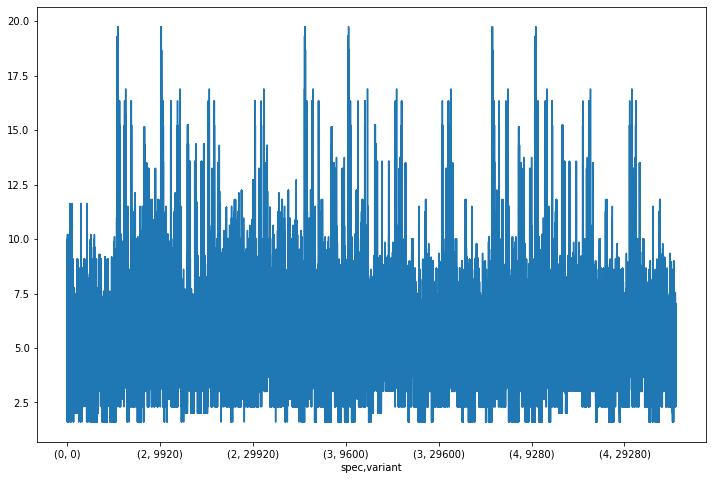

In [99]:
(comparison_squished["limit.downs"]/comparison_squished["real.downs"]).plot(figsize=(12,8))

In [100]:
opti_max = opti.groupby("spec").max()
real_statistics = real_max.groupby("spec").aggregate(["min", "max", "mean"])
compare = real_statistics.join(opti_max)
comparison_opti = compare.compute()

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


### Specification complexity range evolution (natural order)

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='spec'>

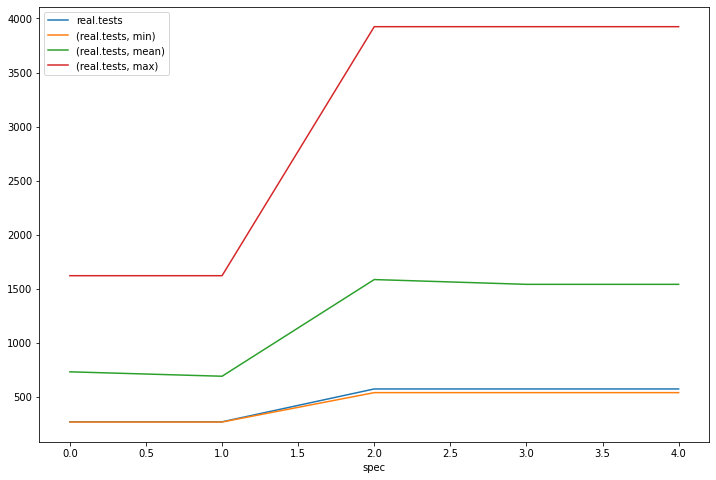

In [101]:
comparison_opti[["real.tests", ("real.tests", "min"), ("real.tests", "mean"), ("real.tests", "max")]].plot(figsize=(12, 8))

### Specification complexity range evolution (size)

<AxesSubplot:xlabel='size', ylabel='diff'>

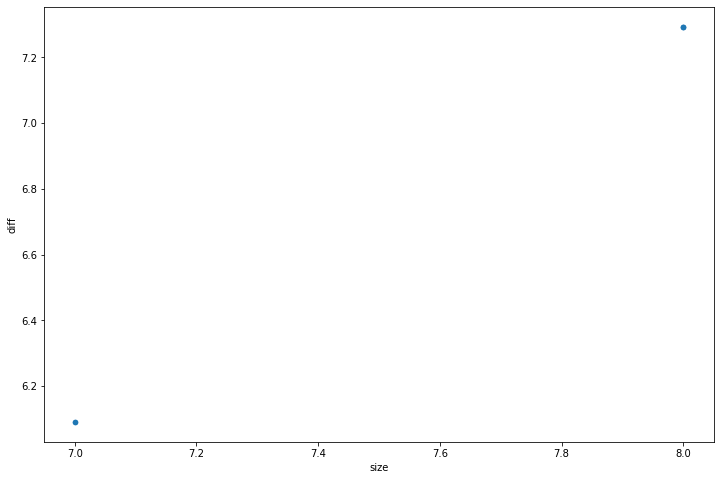

In [102]:
comparison_opti2 = comparison_opti.sort_values(("clocks", "max"))
comparison_opti2["diff"] = comparison_opti2[("real.tests", "max")]/comparison_opti2[("real.tests", "min")]
comparison_opti2["size"] = comparison_opti2[("size","max")]
comparison_opti2["clocks"] = comparison_opti2[("clocks","max")]
comparison_opti2.sort_values("size").plot.scatter(x="size", y="diff",figsize=(12, 8))

<AxesSubplot:xlabel='clocks', ylabel='diff'>

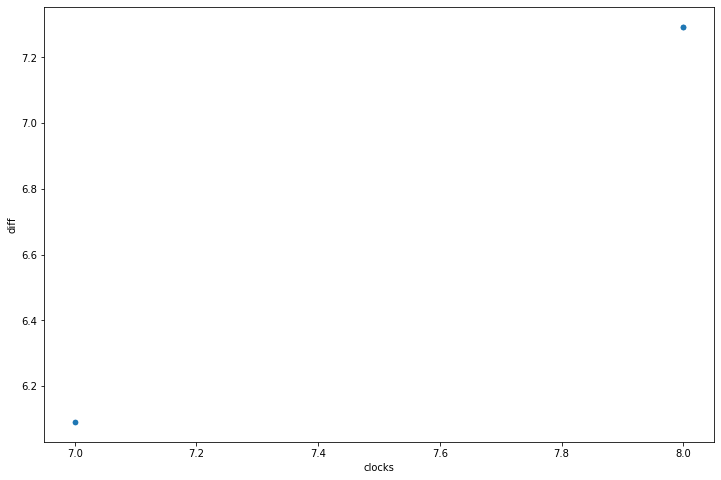

In [103]:
comparison_opti2.sort_values("clocks").plot.scatter(x="clocks", y="diff",figsize=(12, 8))

### All failed to optimize specifications

In [104]:
comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]]


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,comb,real.tests,real.downs
spec,,,,,,,,,,,,,,,,


### Percentage of badly optimized specifications

In [105]:
len(comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]])/len(comparison_opti)

0.0

### Scatter plot of permutations' real test values for each specification

<AxesSubplot:xlabel='spec', ylabel='real.tests'>

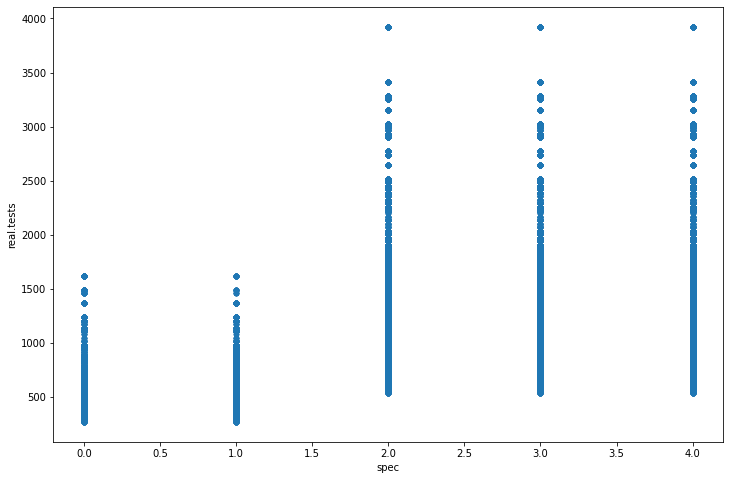

In [106]:
frame = real_max.compute()
frame.reset_index(inplace=True)
frame.plot.scatter(x="spec", y="real.tests", figsize=(12, 8))

### Relative scatter plot

In [107]:
relative_dist = real_max.compute().reset_index(level="variant").join(real_statistics.compute(), on="spec")
relative_dist

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)"
spec,,,,,,,,,,,,,,,,,
0,0,436,176,7,7,266,1620,730.571429,130,532,271.257143,7,7,7.0,7,7,7.0
0,1,308,144,7,7,266,1620,730.571429,130,532,271.257143,7,7,7.0,7,7,7.0
0,2,628,224,7,7,266,1620,730.571429,130,532,271.257143,7,7,7.0,7,7,7.0
0,3,628,224,7,7,266,1620,730.571429,130,532,271.257143,7,7,7.0,7,7,7.0
0,4,372,160,7,7,266,1620,730.571429,130,532,271.257143,7,7,7.0,7,7,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,40315,1844,620,8,8,538,3924,1540.035714,262,1236,554.750000,8,8,8.0,8,8,8.0
4,40316,1844,620,8,8,538,3924,1540.035714,262,1236,554.750000,8,8,8.0,8,8,8.0
4,40317,1844,620,8,8,538,3924,1540.035714,262,1236,554.750000,8,8,8.0,8,8,8.0


In [108]:
def scale_reals(row):
    new_rows = dict()
    test_min = row[("real.tests", "min")]
    test_max = row[("real.tests", "max")]
    if test_max == test_min:
        new_rows["rel_tests"] = 0
    else:
        new_rows["rel_tests"] = (row["real.tests"] - test_min) / (test_max - test_min)
    down_min = row[("real.downs", "min")]
    down_max = row[("real.downs", "max")]
    if down_min == down_max:
        new_rows["rel_downs"] = 0
    else:
        new_rows["rel_downs"] = (row["real.downs"] - down_min) / (down_max - down_min)
    new_rows["size"] = row["size"]
    new_rows["clocks"] = row["clocks"]
    return new_rows
relative_dist = relative_dist.apply(scale_reals, axis=1, result_type='expand')
relative_dist

,rel_tests,rel_downs,size,clocks
spec,,,,
0,0.125554,0.114428,7.0,7.0
0,0.031019,0.034826,7.0,7.0
0,0.267356,0.233831,7.0,7.0
0,0.267356,0.233831,7.0,7.0
0,0.078287,0.074627,7.0,7.0
...,...,...,...,...
4,0.385706,0.367556,8.0,8.0
4,0.385706,0.367556,8.0,8.0
4,0.385706,0.367556,8.0,8.0


In [109]:
relative_dist4 = relative_dist[relative_dist["size"] == 4]

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

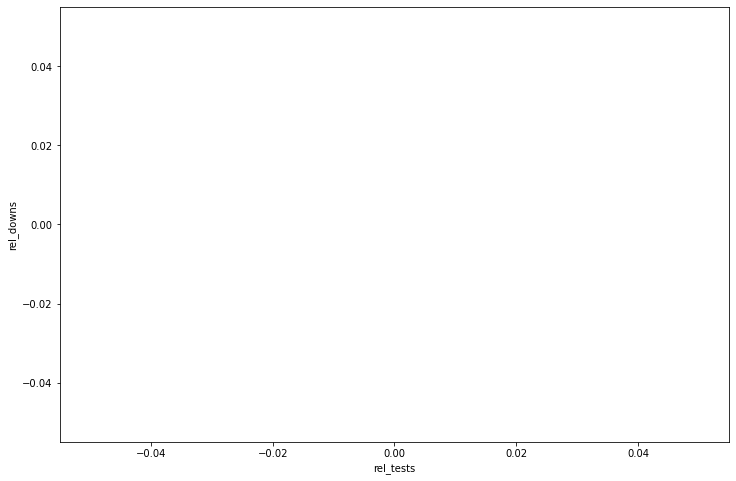

In [110]:
relative_dist4.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.01, figsize=(12, 8))


<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

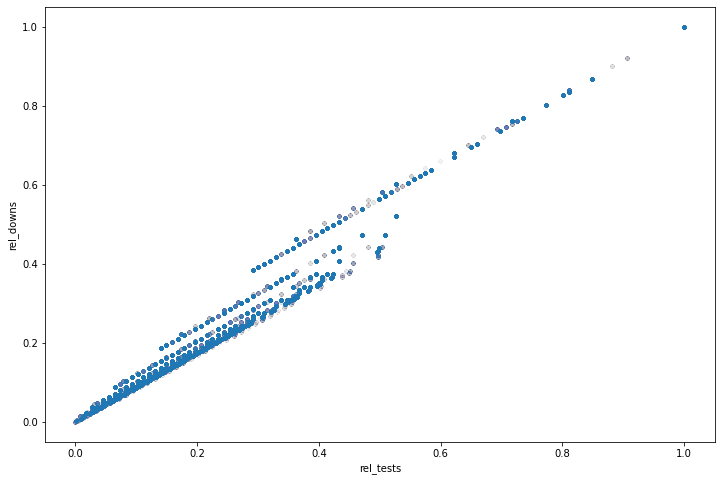

In [111]:
relative_dist.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.005, figsize=(12, 8))


In [112]:
num_points = relative_dist.groupby("spec").aggregate(len).sort_values("rel_tests")

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

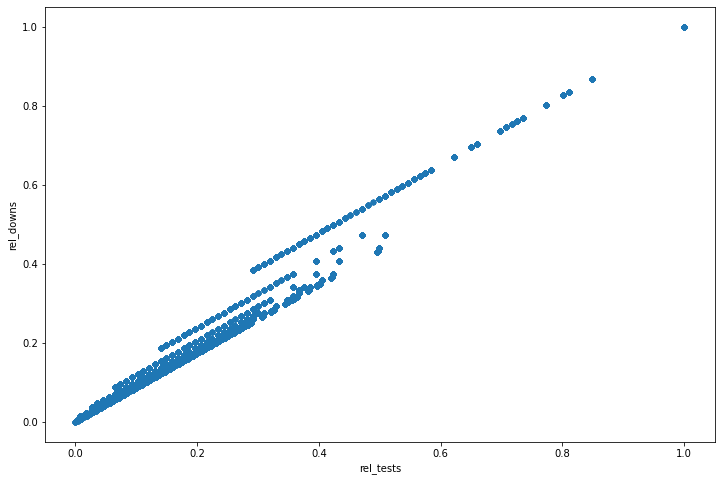

In [113]:
relative_dist.loc[num_points.index[2]].plot.scatter(x="rel_tests", y="rel_downs", figsize=(12, 8))


In [114]:
import os

all_methods_comp = real_statistics
methods = []
for file in os.listdir(dir+"/opti"):
     filename = os.fsdecode(file)
     if filename.endswith(".parquet"):
         table = dd.read_parquet(dir+"opti/"+filename, index=["spec"],columns=["real.tests"])
         table = table.groupby("spec").max()
         method = filename.replace(".parquet", "")
         table = table.rename(columns={"real.tests": method})
         methods.append(method)
         all_methods_comp = all_methods_comp.join(table)
     else:
         continue
all_methods_comp = all_methods_comp.compute()
all_methods_comp

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)",...,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,heatmap.dijkstra,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,,,,,,
0,266,1620,730.571429,130,532,271.257143,7,7,7.0,7,...,380,284,268,284,268,316,268,388.0,268,314
1,266,1620,689.733333,130,532,257.466667,7,7,7.0,7,...,284,316,268,268,268,324,268,500.0,268,500
2,538,3924,1584.264286,262,1236,571.578571,8,8,8.0,8,...,772,636,1020,540,572,644,572,388.0,572,636
3,538,3924,1540.035714,262,1236,554.750000,8,8,8.0,8,...,820,572,636,570,572,772,572,NaN,572,692
4,538,3924,1540.035714,262,1236,554.750000,8,8,8.0,8,...,692,572,1020,820,572,644,572,NaN,572,572


In [115]:
def diffs(row):
    new_row = dict()
    mean = row[("real.tests", "mean")]
    for i,c in enumerate(methods, start=1):
        new_row[c] = int(row[c] < mean or row[("real.tests", "min")] == row[("real.tests", "max")])
    return new_row
diffs_comp = all_methods_comp.copy()
diffs_comp = diffs_comp.apply(diffs, axis=1, result_type='expand')
diffs_comp

,sort_min_weights,tricost.dijkstra,init_weights.dijkstra,networkx.min_front,heatmap.min_front,random,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,heatmap.dijkstra,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,
0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1
4,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1


### Percentage of good optimized specifications by method

In [116]:
diffs_comp.apply(sum, axis=0).sort_values()/len(diffs_comp)

heatmap.min_front         0.6
random                    0.6
heatmap.dijkstra          0.6
sort_min_weights          1.0
tricost.dijkstra          1.0
init_weights.dijkstra     1.0
networkx.min_front        1.0
networkx.dijkstra         1.0
min_out.dijkstra          1.0
min_out.tree_depth        1.0
random.min_front          1.0
init_weights.min_front    1.0
min_out.tree_width        1.0
tricost.min_front         1.0
min_out.min_front         1.0
random.dijkstra           1.0
dtype: float64

### Visualisation of optimization coverage

<AxesSubplot:xlabel='spec'>

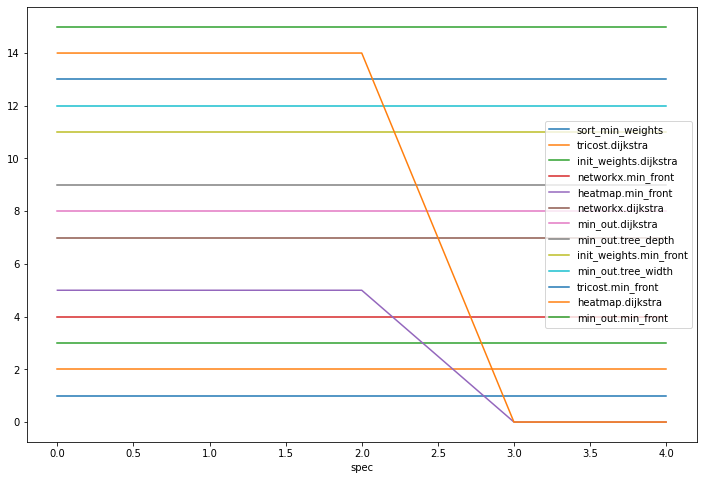

In [117]:
def scale_methods(row):
    new_row = dict()
    for i,c in enumerate(methods, start=1):
        if "random" in c:
            continue
        new_row[c] = i*row[c]
    return new_row
without_rand = diffs_comp.apply(scale_methods, axis=1, result_type='expand')
without_rand.iloc[:100].plot(figsize=(12, 8))

### Cumulative coverage

<AxesSubplot:xlabel='spec'>

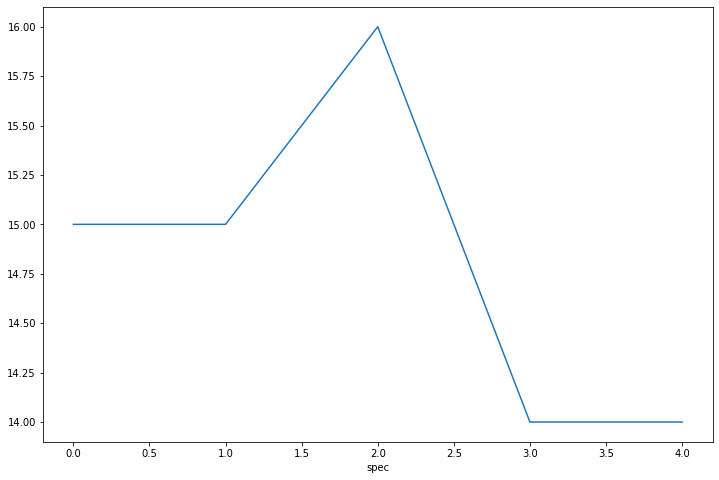

In [118]:
cumulative_comp = diffs_comp.apply(sum, axis=1)
cumulative_comp.plot(figsize=(12, 8))

### Uncovered specifications

In [119]:
cumulative_comp[cumulative_comp == 0]

Series([], dtype: int64)

In [120]:
starting = real_max.compute().reset_index(level="variant")
starting = starting[starting["variant"] == 0]
gain = starting.join(all_methods_comp)
gain = gain[(gain[("real.tests", "max")]/gain[("real.tests", "min")])>1.05]
gain

,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)",...,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,heatmap.dijkstra,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,,,,,,
0,0,436,176,7,7,266,1620,730.571429,130,532,...,380,284,268,284,268,316,268,388.0,268,314
1,0,436,176,7,7,266,1620,689.733333,130,532,...,284,316,268,268,268,324,268,500.0,268,500
2,0,884,356,8,8,538,3924,1584.264286,262,1236,...,772,636,1020,540,572,644,572,388.0,572,636
3,0,884,356,8,8,538,3924,1540.035714,262,1236,...,820,572,636,570,572,772,572,NaN,572,692
4,0,884,356,8,8,538,3924,1540.035714,262,1236,...,692,572,1020,820,572,644,572,NaN,572,572


### Gain in percentage relative to input specification

<AxesSubplot:ylabel='Frequency'>

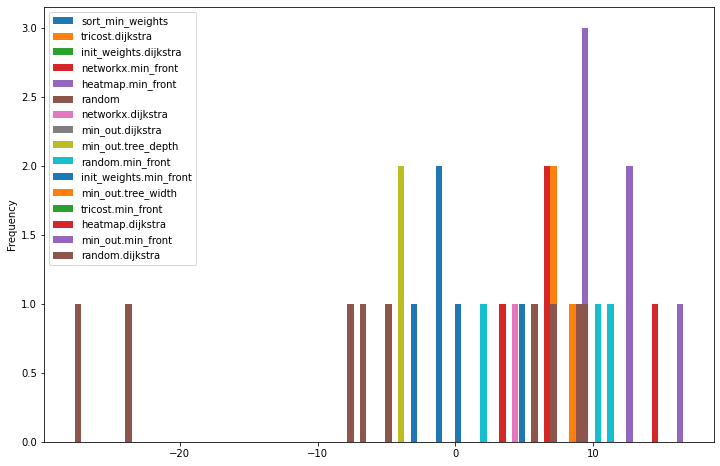

In [121]:
def gains_minus_start(row):
    new_row = dict()
    real = float(row["real.tests"])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (real - float(row[c])) / diff * 100
    return new_row
gain_from_start = gain.apply(gains_minus_start, axis=1, result_type='expand')
gain_from_start.plot.hist(bins=96, alpha=1,figsize=(12, 8))

### Gain in percentage relative to input specification (specific method)

<AxesSubplot:ylabel='Frequency'>

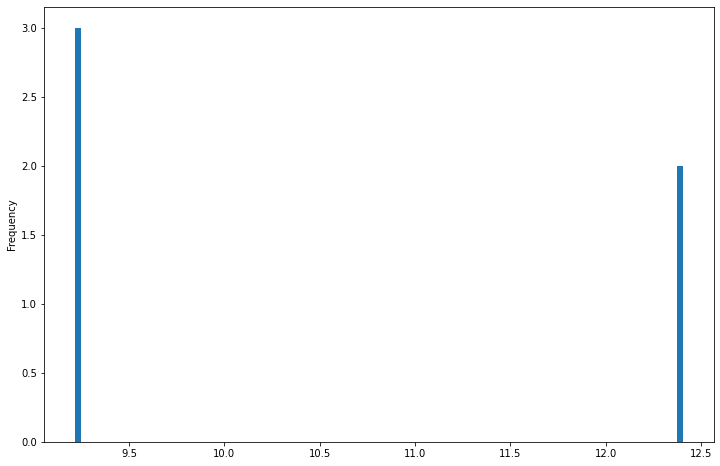

In [122]:
gain_from_start["init_weights.min_front"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

### What are the 0 specs?

In [123]:
strange_0_specs = gain_from_start[["init_weights.min_front", ]][gain_from_start["init_weights.min_front"] == 0]
strange_0_specs = strange_0_specs.join(real_statistics.compute()).join(starting)
strange_0_specs

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,init_weights.min_front,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,real.tests,real.downs,size,clocks
spec,,,,,,,,,,,,,,,,,,


In [124]:
if len(strange_0_specs) != 0:
    relative_dist.loc[strange_0_specs.index[-1]].plot.scatter(x="rel_tests", y="rel_downs", alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<AxesSubplot:ylabel='Frequency'>

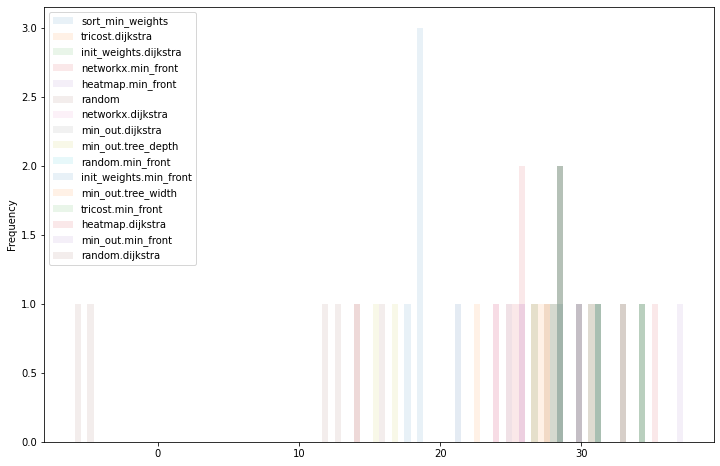

In [125]:
def gains_from_mean(row):
    new_row = dict()
    mean = float(row[("real.tests", "mean")])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (mean - float(row[c])) / diff * 100
    return new_row
gain_from_mean = all_methods_comp.apply(gains_from_mean, axis=1, result_type='expand')
gain_from_mean.plot.hist(bins=96, alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<AxesSubplot:ylabel='Frequency'>

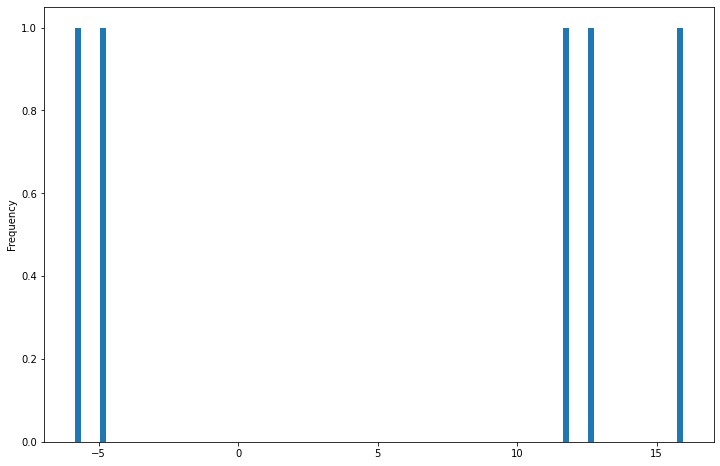

In [126]:
gain_from_mean["random"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

<AxesSubplot:ylabel='Frequency'>

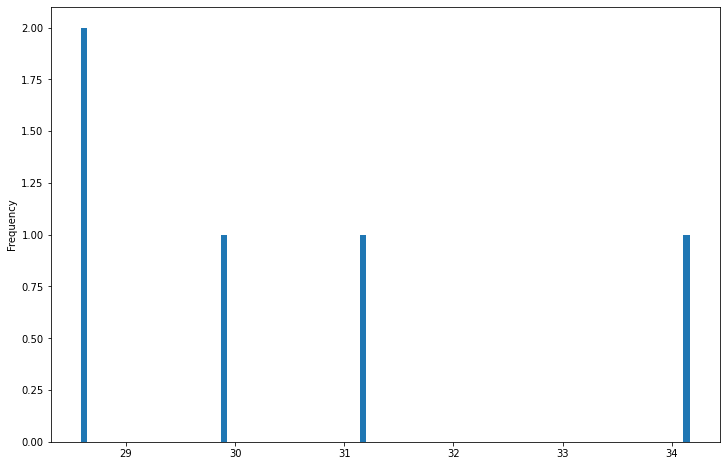

In [127]:
gain_from_mean["init_weights.min_front"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

### Gain characteristics per method

In [128]:
gain_from_mean.aggregate(["mean", "std"], axis=0).transpose().sort_values("mean", ascending=False)

,mean,std
heatmap.min_front,31.025642,5.760344
init_weights.min_front,30.476968,2.318545
tricost.min_front,30.476968,2.318545
min_out.min_front,30.476968,2.318545
init_weights.dijkstra,30.098941,2.576748
tricost.dijkstra,29.531621,2.093658
min_out.dijkstra,29.153594,2.180358
random.min_front,28.976603,4.577166
networkx.min_front,28.019722,3.836844
min_out.tree_width,26.908883,2.853497


### Complexity grow speed (by clocks)

<AxesSubplot:xlabel='clocks'>

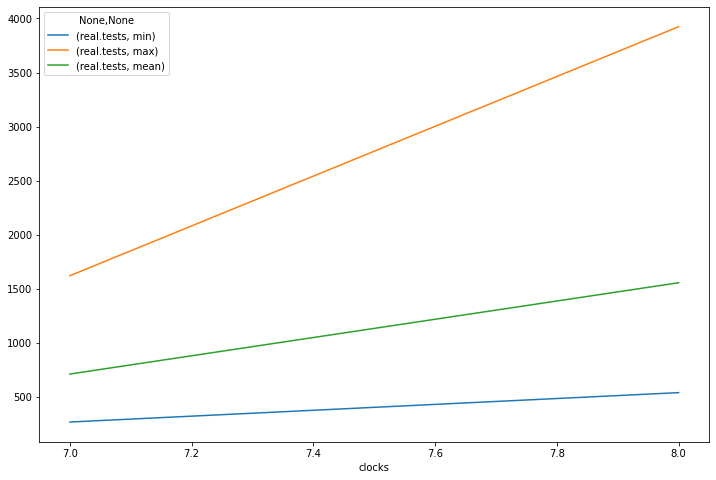

In [129]:
real_max[["clocks", "real.tests"]].groupby("clocks").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

### Complexity grow speed (by size)

<AxesSubplot:xlabel='size'>

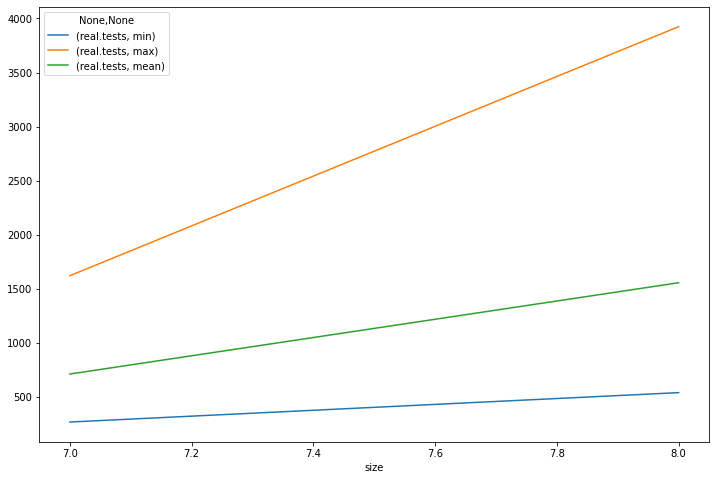

In [130]:
real_max[["size", "real.tests"]].groupby("size").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

In [131]:
comparison_size_clock = comparison_squished.copy()
comparison_size_clock["approx.tests"] = comparison_size_clock["approx.tests"].astype(np.int64)
comparison_size_clock["diff_appr_real"] = ((comparison_size_clock["approx.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock["diff_limit_real"] = ((comparison_size_clock["limit.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock

real.tests  real.downs  size  clocks  approx.tests  \
spec variant                                                       
0    0               436         176     7       7          2204   
     1               308         144     7       7          1436   
     2               628         224     7       7          2588   
     3               628         224     7       7          2588   
     4               372         160     7       7          1436   
...                  ...         ...   ...     ...           ...   
4    40315          1844         620     8       8          5748   
     40316          1844         620     8       8          5748   
     40317          1844         620     8       8          5748   
     40318          1844         620     8       8          5748   
     40319          1844         620     8       8          5748   

              approx.downs  limit.tests  limit.downs  diff_appr_real  \
spec variant                                                           
0    0                1320         2924         1756        4.055046   
     1                 744         1900          988        3.662338   
     2                1416         3436         1884        3.121019   
     3                1416         3436         1884        3.121019   
     4                 744         1900          988        2.860215   
...                    ...          ...          ...             ...   
4    40315            2988         5748         2988        2.117137   
     40316            2988         5748         2988        2.117137   
     40317            2988         5748         2988        2.117137   
     40318            2988         5748         2988        2.117137   
     40319            2988         5748         2988        2.117137   

              diff_limit_real  
spec variant                   
0    0               5.706422  
     1               5.168831  
     2               4.471338  
     3               4.471338  
     4               4.107527  
...                       ...  
4    40315           2.117137  
     40316           2.117137  
     40317           2.117137  
     40318           2.117137  
     40319           2.117137  

[131040 rows x 10 columns]

In [132]:
comparison_size_clock.groupby("size").aggregate("count")
comparison_size_clock.groupby("clocks").aggregate("count")


,real.tests,real.downs,clocks,approx.tests,approx.downs,limit.tests,limit.downs,diff_appr_real,diff_limit_real
size,,,,,,,,,
7,10080,10080,10080,10080,10080,10080,10080,10080,10080
8,120960,120960,120960,120960,120960,120960,120960,120960,120960


,real.tests,real.downs,size,approx.tests,approx.downs,limit.tests,limit.downs,diff_appr_real,diff_limit_real
clocks,,,,,,,,,
7,10080,10080,10080,10080,10080,10080,10080,10080,10080
8,120960,120960,120960,120960,120960,120960,120960,120960,120960


### Growth speed of difference of real and approximate complexities (by size)

<AxesSubplot:xlabel='size'>

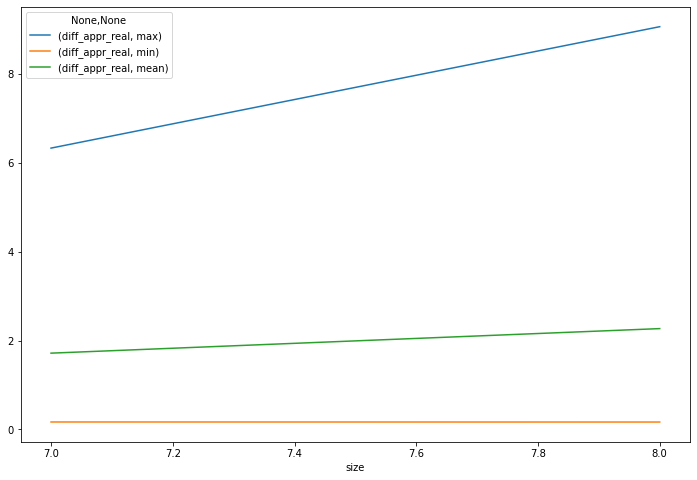

In [133]:
comparison_size_clock[["size", "diff_appr_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='size'>

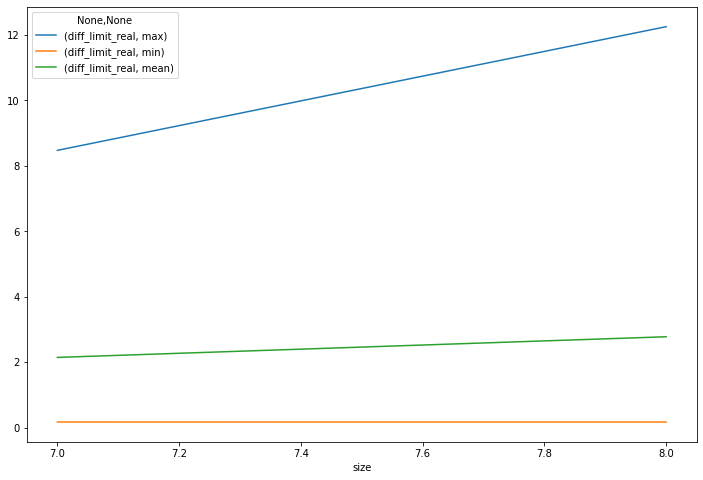

In [134]:
comparison_size_clock[["size", "diff_limit_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))


### Growth speed of difference of real and approximate complexities (by clock)

<AxesSubplot:xlabel='clocks'>

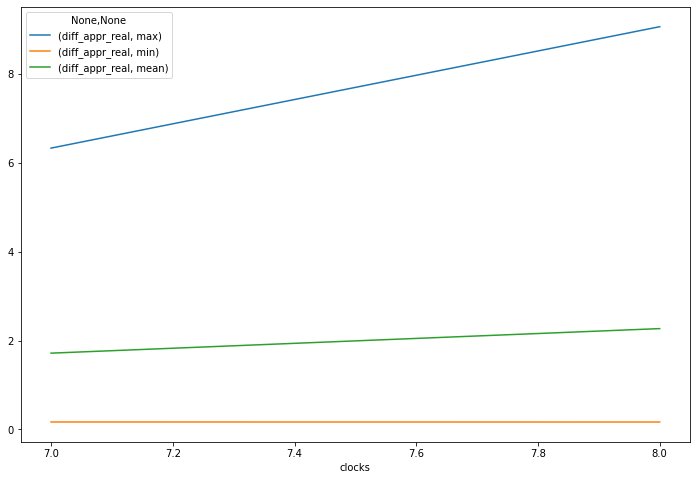

In [135]:
comparison_size_clock[["clocks", "diff_appr_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='clocks'>

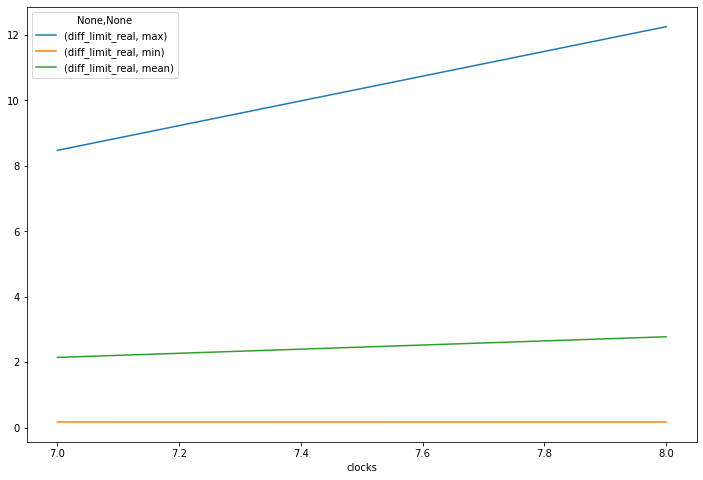

In [136]:
comparison_size_clock[["clocks", "diff_limit_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

### Check if approximations allow specification comparison

In [137]:
check_order = comparison_squished[["real.tests", "approx.tests"]].reset_index(level="variant").drop("variant", axis=1).groupby("spec").aggregate(list)
check_order

,real.tests,approx.tests
spec,,
0,"[436, 308, 628, 628, 372, 500, 404, 276, 468, ...","[2204, 1436, 2588, 2588, 1436, 1436, 1148, 764..."
1,"[436, 308, 628, 628, 372, 500, 404, 276, 468, ...","[2204, 1436, 2588, 2588, 1436, 1436, 1148, 764..."
2,"[884, 628, 1268, 1268, 756, 1012, 820, 564, 94...","[4420, 2884, 5188, 5188, 2884, 2884, 2308, 154..."
3,"[884, 628, 1268, 1268, 756, 1012, 820, 564, 94...","[4420, 2884, 5188, 5188, 2884, 2884, 2308, 154..."
4,"[884, 628, 1268, 1268, 756, 1012, 820, 564, 94...","[4420, 2884, 5188, 5188, 2884, 2884, 2308, 154..."


In [138]:
def order_holds(orig: List[int], aprox: List[int]) -> float:
    candidates = list(zip(orig, aprox))
    hold_times = 0
    count = 0
    for (lorig, laprox), (rorig, raprox) in combinations(candidates, 2):
        ok = (lorig < rorig and laprox < raprox) or \
          (lorig > rorig and laprox > raprox) or \
          (lorig == rorig and laprox == raprox)
        hold_times += int(ok)
        count +=1
    return hold_times/count

check_order["holds"] = check_order.apply(lambda row: order_holds(row["real.tests"], row["approx.tests"]), axis=1)
check_order.holds.mean()

0.7416237938549525